In [ ]:
#!wget http://air.ug/downloads/plasmodium-images.zip

# We need this for the server.
import matplotlib
matplotlib.use('Agg')

In [2]:
import keras
import keras.backend as K
from keras.datasets import mnist

model = keras.models.load_model('my_model.h5')



# input image dimensions
img_rows, img_cols = 28, 28

# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()
training_size = 60000

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(training_size, 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)


# input_shape refers to the shape of the input data
# each element represents a number of dimensions
# ie. img_rows, img_cols, 1 where 1 represents the channel (one of three values: RGB)

print(input_shape)

"""
print(input_shape)
img_i = 0
row = 0
col = 24
chan = 0 # red

for i in range(0, 10):
    print(x_train[img_i][row][i][chan])
"""

(28, 28, 1)


'\nprint(input_shape)\nimg_i = 0\nrow = 0\ncol = 24\nchan = 0 # red\n\nfor i in range(0, 10):\n    print(x_train[img_i][row][i][chan])\n'

In [80]:
from matplotlib.pyplot import imshow
from keras import backend as K
import numpy as np

input_img = model.layers[0].input
layer_output = model.layers[-1].output

print(K.learning_phase())
# Tensor("dropout_9/keras_learning_phase:0", dtype=bool)


print(model.layers[0].input)
# Tensor("conv2d_9_input_22:0", shape=(?, 28, 28, 1), dtype=float32)

print(model.layers[0].output)
# Tensor("conv2d_9_22/Relu:0", shape=(?, 26, 26, 32), dtype=float32)




# get_ith_layer_output = K.function([model.layers[0].input, K.learning_phase()],
#                                   [model.layers[3].output])

# output in test mode = 0
# layer_output = get_3rd_layer_output([x, 0])[0]

# output in train mode = 1
# layer_output = get_3rd_layer_output([x, 1])[0]


#with K.get_session().as_default():
#    print(input_img.eval()[1:2])

Tensor("conv2d_9_input_22:0", shape=(?, 28, 28, 1), dtype=float32)
Tensor("dropout_9/keras_learning_phase:0", dtype=bool)
Tensor("conv2d_9_22/Relu:0", shape=(?, 26, 26, 32), dtype=float32)


In [117]:
from scipy.misc import imsave
import numpy as np
import time
from keras import backend as K

img_width = 28
img_height = img_width

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

model.summary()

# this is the placeholder for the input images
input_img = model.input
input_img = [x_train[0]]
print(input_img[0].shape)

print(K.image_data_format())

channels_num = 1

# get the symbolic outputs of each "key" layer (we gave them unique names).
layer_dict = dict([(layer.name, layer) for layer in model.layers[1:]])
print(layer_dict)
# layer_name = 'conv2d_10'
layer_name = 'conv2d_10'
# layer_index = 0

def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + 1e-5)


kept_filters = []
for filter_index in range(0, 20):
    # we only scan through the first 200 filters,
    # but there are actually 512 of them
    print('Processing filter %d' % filter_index)
    start_time = time.time()

    # we build a loss function that maximizes the activation
    # of the nth filter of the layer considered
    layer_output = layer_dict[layer_name].output
#     layer_output = layer_dict[layer_index].output
    loss = K.mean(layer_output[:, :, :, :])
    print(layer_output[:, :, :, filter_index])
    raise Exception()

    # we compute the gradient of the input picture wrt this loss
    grads = K.gradients(loss, input_img)
    if grads is not None:
        print(grads)
        raise Exception()

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads given the input picture
    iterate = K.function([input_img], [loss, grads])

    # step size for gradient ascent
    step = 1.

    # we start from a gray image with some random noise
    input_img_data = np.random.random((1, img_width, img_height, channels_num))
    input_img_data = (input_img_data - 0.5) * 20 + img_width

    # we run gradient ascent for 20 steps
    for i in range(20):
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step

        print('Current loss value:', loss_value)
        if loss_value <= 0.:
            # some filters get stuck to 0, we can skip them
            break

    # decode the resulting input image
    if loss_value > 0:
        img = deprocess_image(input_img_data[0])
        kept_filters.append((img, loss_value))
    end_time = time.time()
    print('Filter %d processed in %ds' % (filter_index, end_time - start_time))

# we will stich the best 64 filters on a 8 x 8 grid.
n = 8

# the filters that have the highest loss are assumed to be better-looking.
# we will only keep the top 64 filters.
kept_filters.sort(key=lambda x: x[1], reverse=True)
kept_filters = kept_filters[:n * n]

# build a black picture with enough space for
# our 8 x 8 filters of size 128 x 128, with a 5px margin in between
margin = 5
width = n * img_width + (n - 1) * margin
height = n * img_height + (n - 1) * margin
stitched_filters = np.zeros((width, height, channels_num))

# fill the picture with our saved filters
for i in range(n):
    for j in range(n):
        img, loss = kept_filters[i * n + j]
        stitched_filters[(img_width + margin) * i: (img_width + margin) * i + img_width,
                         (img_height + margin) * j: (img_height + margin) * j + img_height, :] = img

# save the result to disk
#imsave('stitched_filters_%dx%d.png' % (n, n), stitched_filters)
imshow(stitched_filters)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_10 (Dropout)         (None, 128)               0         
__________

Exception: 

Convolutional neural networks.

 - what is the difference between a fully-connected layer
 - what do they mean by a function being linear vs activation
 - can you explain the mathematical intuition behind starting with convolutions but the final layers being connected dense neurons
 - how does visualising activations work? why do we set it to linear instead of softmax?

In [3]:
from __future__ import print_function

import numpy as np
import keras

from keras.datasets import mnist
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Activation, Input
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from keras.callbacks import TensorBoard


batch_size = 128
num_classes = 10
epochs = 2


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()

activation1 = 'selu'
# activation1 = 'relu'

model.add(Conv2D(32, kernel_size=(3, 3),
                 activation=activation1,
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation=activation1))

model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

# Matrix => Vector
model.add(Flatten())

model.add(Dense(128, activation=activation1))

model.add(Dropout(0.5))

model.add(Dense(num_classes, activation='softmax', name='preds'))




model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(),
              metrics=['accuracy'])


tensorboard = TensorBoard(log_dir='./tboard', histogram_freq=2,
                          write_graph=True, write_images=True)

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
         callbacks=[tensorboard])

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 48s - loss: 0.2423 - acc: 0.9261 - val_loss: 0.0910 - val_acc: 0.9710
Epoch 2/2
60000/60000 [==============================] - 17s - loss: 0.1130 - acc: 0.9657 - val_loss: 0.0641 - val_acc: 0.9782
Test loss: 0.0641439241051
Test accuracy: 0.9782


In [17]:
%ls tboard
model.save('my_model.h5')

events.out.tfevents.1504013298.saturn3.eng.uts.edu.au
events.out.tfevents.1504013516.saturn3.eng.uts.edu.au


In [12]:
#!pip install --upgrade --user pips
!pip install --user keras-vis

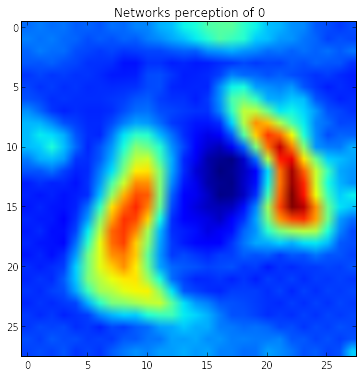

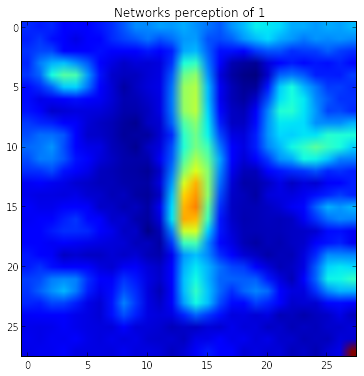

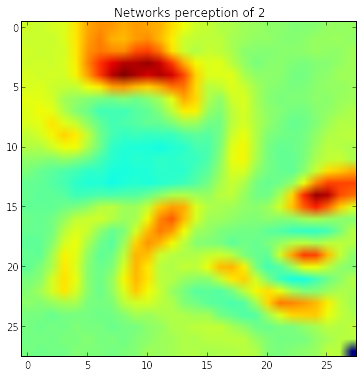

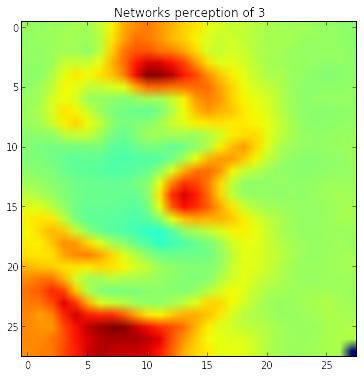

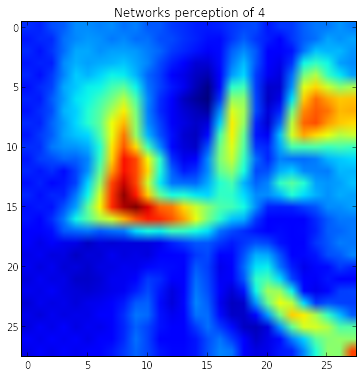

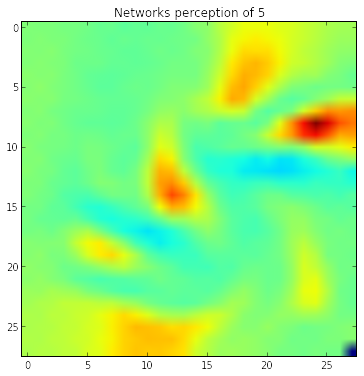

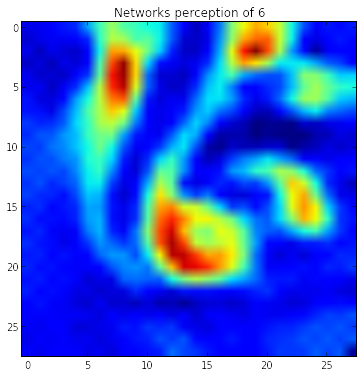

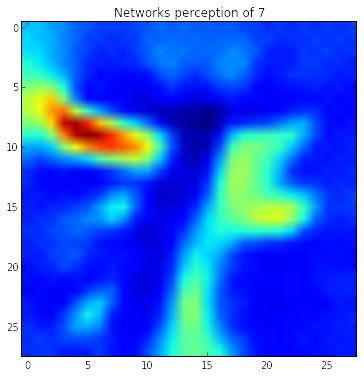

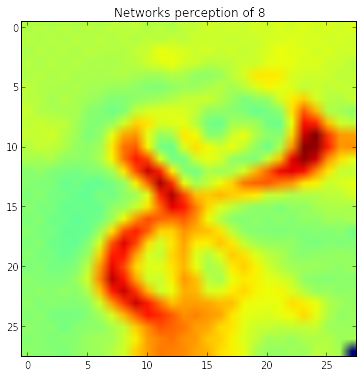

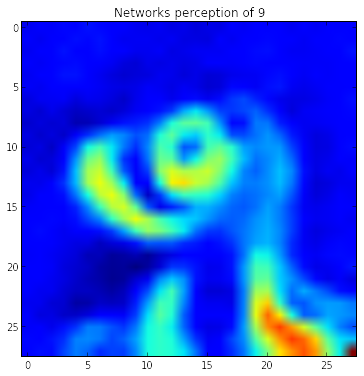

In [9]:
from vis.visualization import visualize_activation
from vis.utils import utils
from keras import activations

import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (18, 6)

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.
#layer_idx = utils.find_layer_idx(model, 'preds')
layer_idx = -1

# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

# This is the output node we want to maximize.
filter_idx = 8
#    img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
#img = visualize_activation(model, layer_idx, filter_indices=filter_idx)
#plt.imshow(img[..., 0])

for output_idx in np.arange(10):
    # Lets turn off verbose output this time to avoid clutter and just see the output.
    img = visualize_activation(model, layer_idx, filter_indices=output_idx, input_range=(0., 1.))
    plt.figure()
    plt.title('Networks perception of {}'.format(output_idx))
    plt.imshow(img[..., 0])

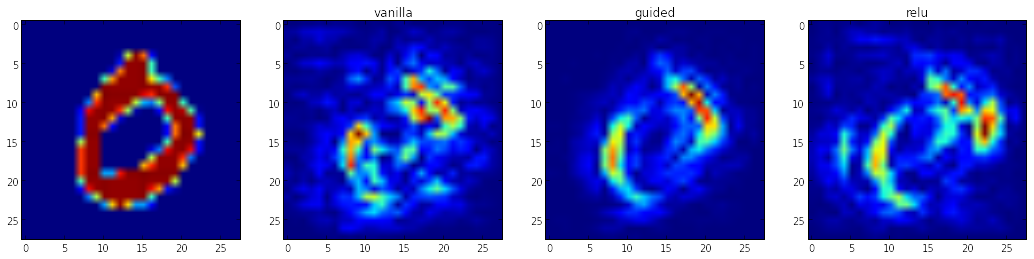

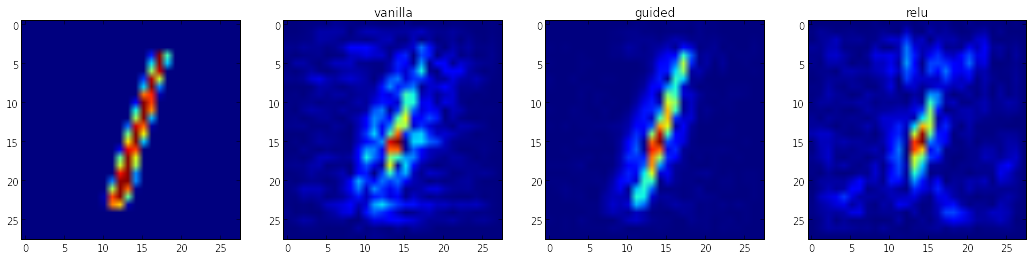

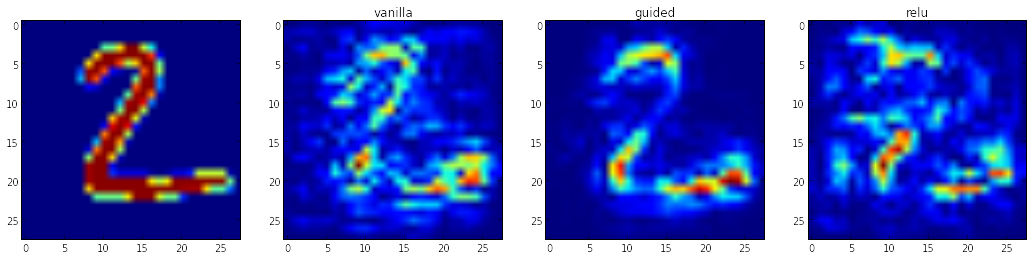

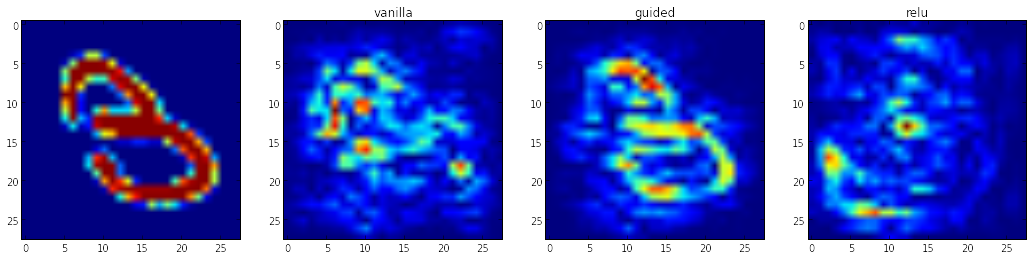

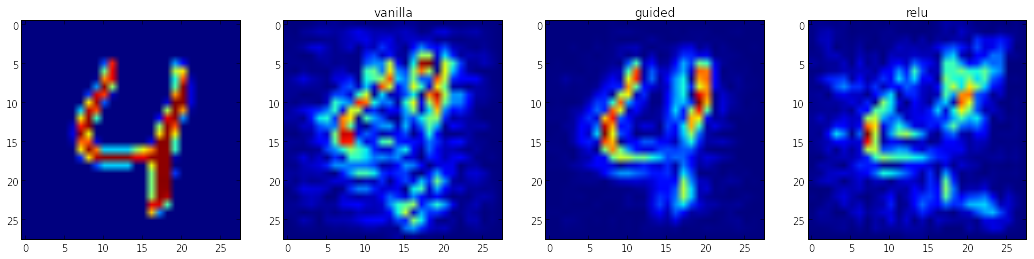

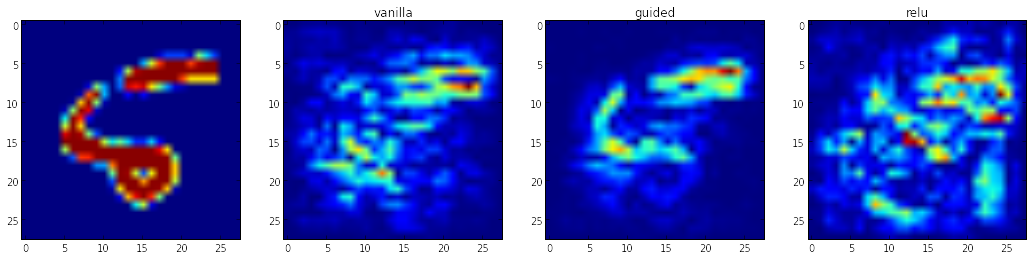

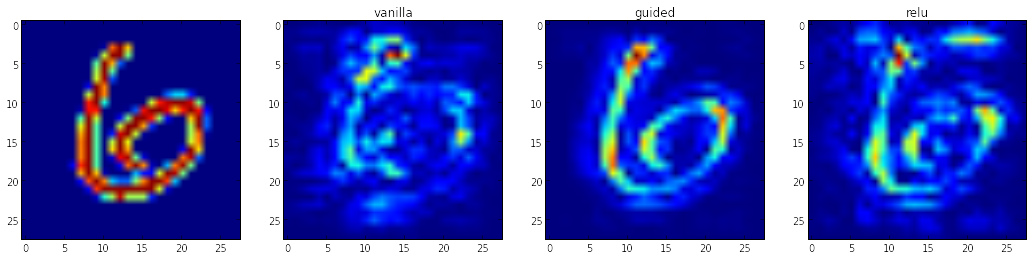

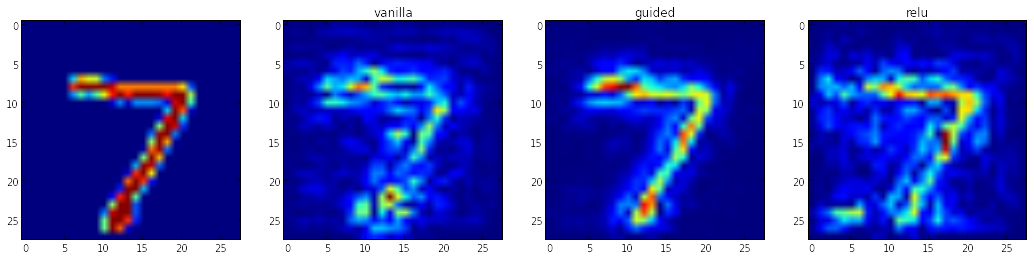

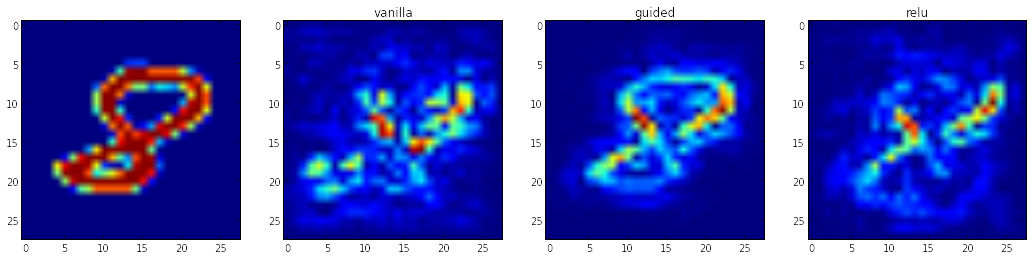

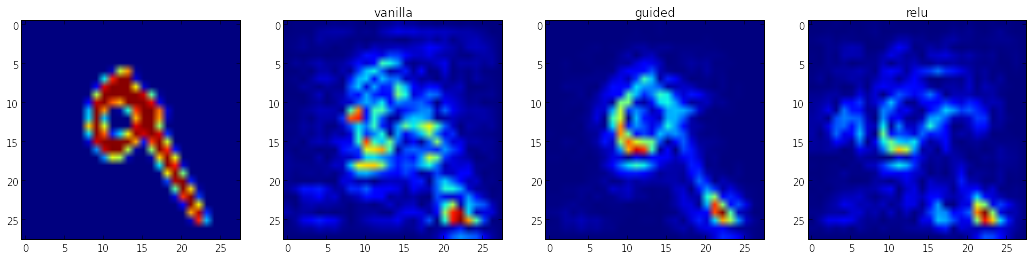

In [6]:
from vis.visualization import visualize_saliency

for class_idx in np.arange(10):    
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        heatmap = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                     seed_input=x_test[idx], backprop_modifier=modifier)
        if modifier is None:
            modifier = 'vanilla'
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(heatmap)

In [45]:
model.layers

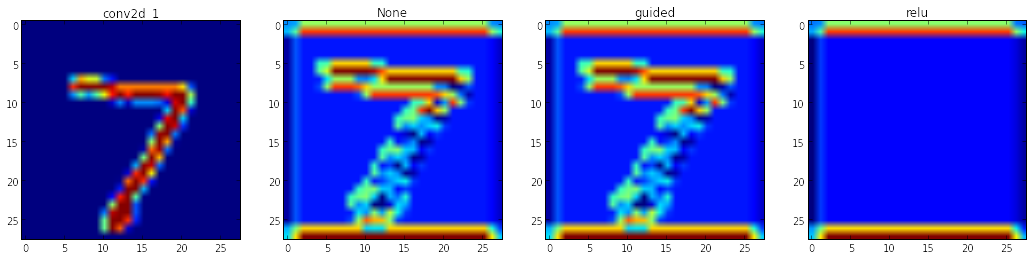

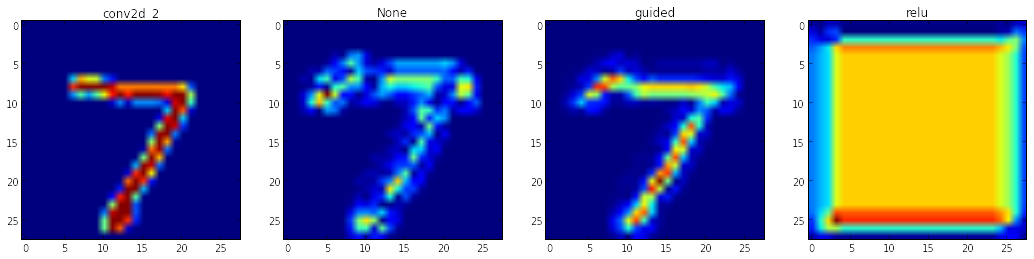

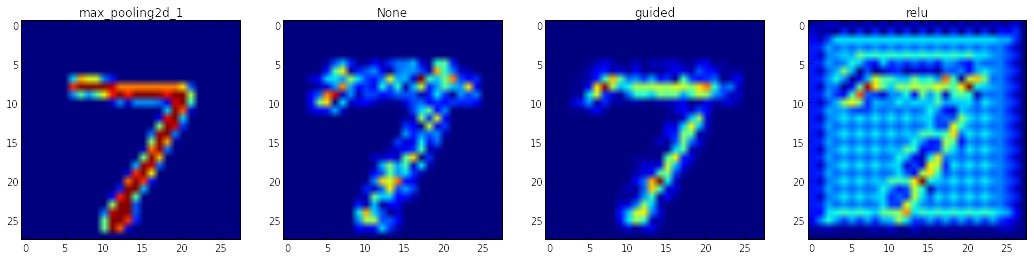

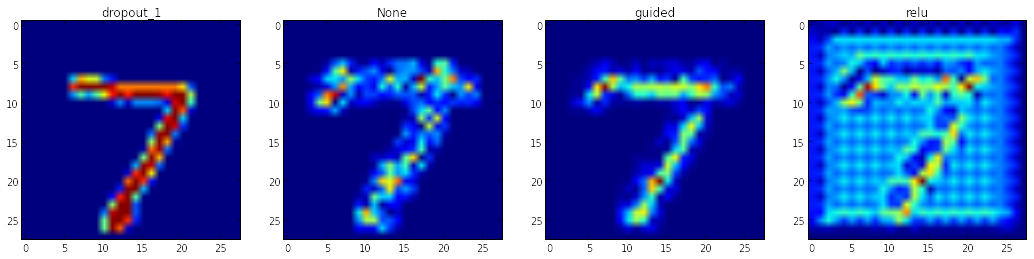

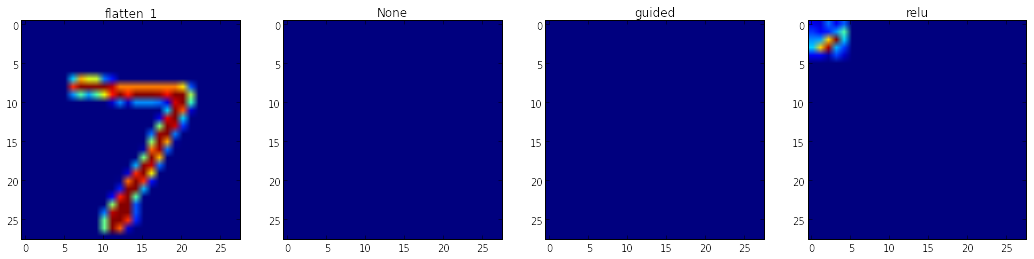

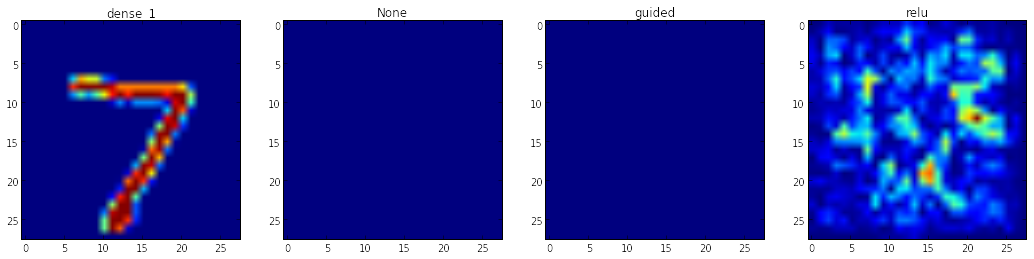

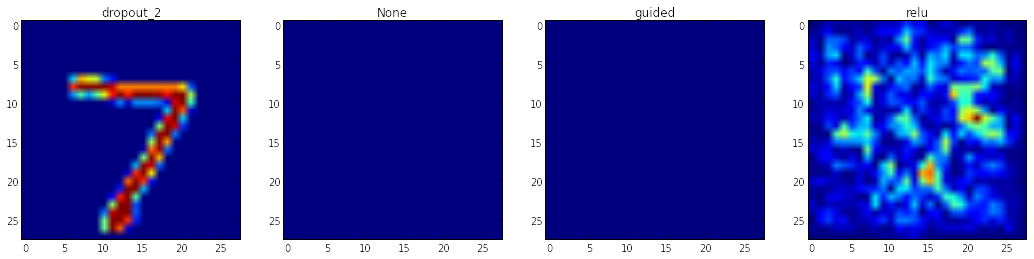

In [7]:
from vis.visualization import visualize_saliency

class_idx = 7
layers = 7

for layer in np.arange(layers):
    layer_idx = layer
    indices = np.where(y_test[:, class_idx] == 1.)[0]
    idx = indices[0]

    f, ax = plt.subplots(1, 4)
    ax[0].set_title(model.layers[layer_idx].name)
    ax[0].imshow(x_test[idx][..., 0])
    
    for i, modifier in enumerate([None, 'guided', 'relu']):
        heatmap = visualize_saliency(model, layer_idx, filter_indices=class_idx, 
                                     seed_input=x_test[idx], backprop_modifier=modifier)
        ax[i+1].set_title(modifier)    
        ax[i+1].imshow(heatmap)

In [9]:
print(model.layers[0])